<a href="https://colab.research.google.com/github/tanqing2001/datafile/blob/main/Final_Prj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
from pylab import rcParams
import matplotlib.pyplot as plt
import warnings
import itertools
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
import math
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [2]:
#dateparse = lambda x: pd.datetime.strptime(x, '%d-%b-%y')
def dateparse(x):
    try:
        # Try parsing the date with the first format (before April 21, 2020)
        return pd.to_datetime(x, format='%d-%b-%y')
        #return pd.to_datetime(x, format='%m/%d/%Y')  ##GOLD
    except ValueError:
        # If the first format fails, try the second format (on or after April 22, 2020)
        return pd.to_datetime(x, format='%b %d, %Y')

#Read csv file
url = "https://raw.githubusercontent.com/tanqing2001/datafile/main/OilPrices.csv"
#url = "https://raw.githubusercontent.com/tanqing2001/datafile/main/GOLD.csv" #GOLD

df = pd.read_csv(url,parse_dates=['Date'], date_parser=dateparse)
df.head(5)

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [79]:
df.shape

(6069, 1)

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(ascending=True, inplace=True)
df=df.loc[datetime.date(year=2000,month=1,day=1):]

In [ ]:
df.tail(5)

,Price
Date,
2023-11-17,77.53
2023-11-20,80.47
2023-11-21,82.13
2023-11-22,82.40
2023-11-23,81.63


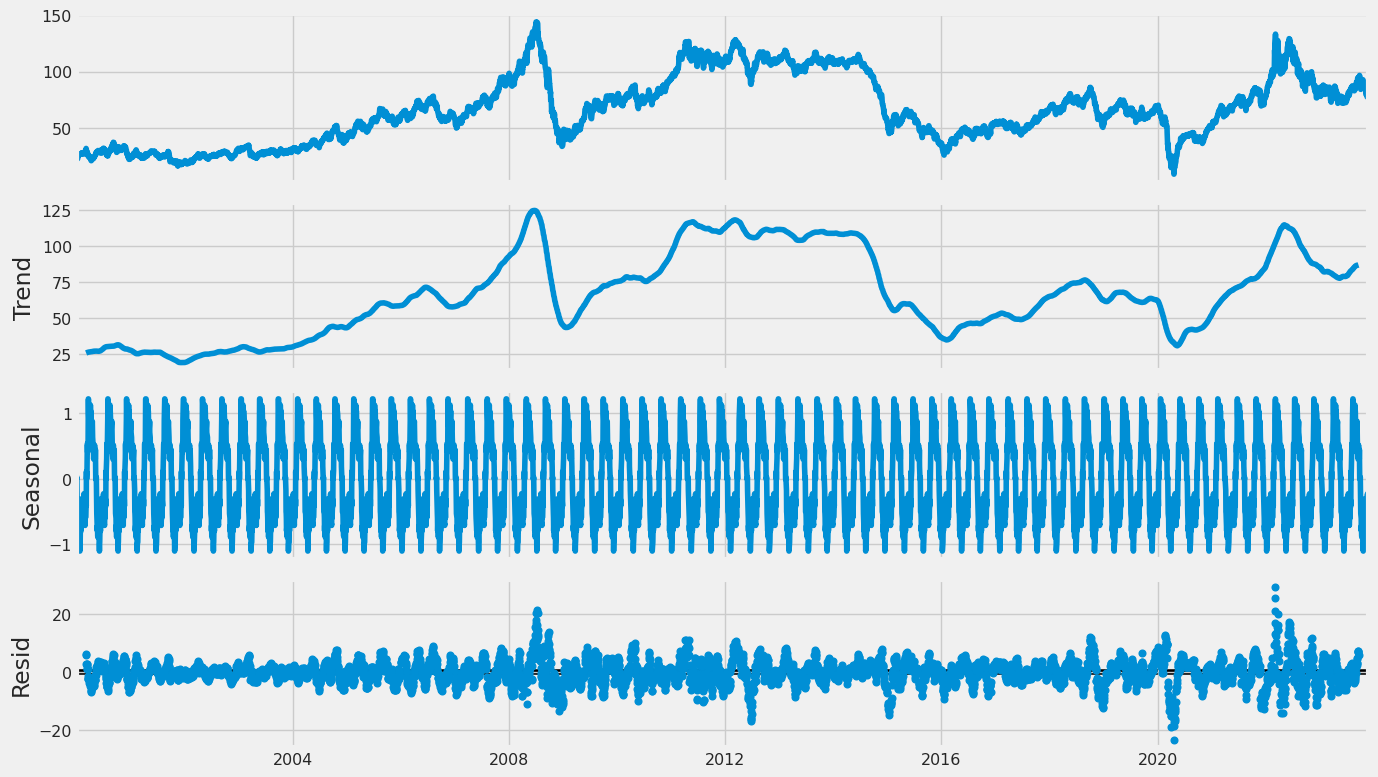

In [128]:
rcParams['figure.figsize'] = 14, 8
decomposition = sm.tsa.seasonal_decompose(df, model='additive', period = 90)
fig = decomposition.plot()
plt.show()

In [4]:
# normalize the data_set
sc = MinMaxScaler(feature_range = (0, 1))
df = sc.fit_transform(df)

In [5]:
# split into train and test sets
train_size = int(len(df) * 0.70)
test_size = len(df) - train_size
train, test = df[0:train_size, :], df[train_size:len(df), :]

In [6]:
# convert an array of values into a data_set matrix def
def create_data_set(_data_set, _look_back=1):
    data_x, data_y = [], []
    for i in range(len(_data_set) - _look_back - 1):
        a = _data_set[i:(i + _look_back), 0]
        data_x.append(a)
        data_y.append(_data_set[i + _look_back, 0])
    return np.array(data_x), np.array(data_y)

In [7]:
# reshape into X=t and Y=t+1
look_back =60
X_train,Y_train,X_test,Ytest = [],[],[],[]
X_train,Y_train=create_data_set(train,look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test,Y_test=create_data_set(test,look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [8]:
# create and fit the LSTM network model
model = Sequential()

model.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.1))

model.add(LSTM(units = 60, return_sequences = True))
model.add(Dropout(0.1))

model.add(LSTM(units = 60))
model.add(Dropout(0.1))

model.add(Dense(units = 1))


model.compile(optimizer = 'adam', loss = 'mean_squared_error')
reduce_lr = ReduceLROnPlateau(monitor='val_loss',patience=5)
history =model.fit(X_train, Y_train, epochs = 20, batch_size = 16,validation_data=(X_test, Y_test), callbacks=[reduce_lr],shuffle=False)

Epoch 1/20
262/262 [==============================] - 45s 144ms/step - loss: 0.0049 - val_loss: 0.0594 - lr: 0.0010
Epoch 2/20
262/262 [==============================] - 41s 156ms/step - loss: 0.0083 - val_loss: 0.0691 - lr: 0.0010
Epoch 3/20
262/262 [==============================] - 26s 98ms/step - loss: 0.0126 - val_loss: 0.0563 - lr: 0.0010
Epoch 4/20
262/262 [==============================] - 26s 99ms/step - loss: 0.0186 - val_loss: 0.0436 - lr: 0.0010
Epoch 5/20
262/262 [==============================] - 28s 105ms/step - loss: 0.0214 - val_loss: 0.0358 - lr: 0.0010
Epoch 6/20
262/262 [==============================] - 28s 105ms/step - loss: 0.0169 - val_loss: 0.0244 - lr: 0.0010
Epoch 7/20
262/262 [==============================] - 27s 103ms/step - loss: 0.0112 - val_loss: 0.0143 - lr: 0.0010
Epoch 8/20
262/262 [==============================] - 27s 103ms/step - loss: 0.0064 - val_loss: 0.0026 - lr: 0.0010
Epoch 9/20
262/262 [==============================] - 27s 102ms/step - los

In [9]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

55/55 [==============================] - 1s 27ms/step


In [10]:
# invert predictions
train_predict = sc.inverse_transform(train_predict)
Y_train = sc.inverse_transform([Y_train])
test_predict = sc.inverse_transform(test_predict)
Y_test = sc.inverse_transform([Y_test])

Train Root Mean Squared Error: 2.3054416298179627
Test Root Mean Squared Error: 2.7119403568206444


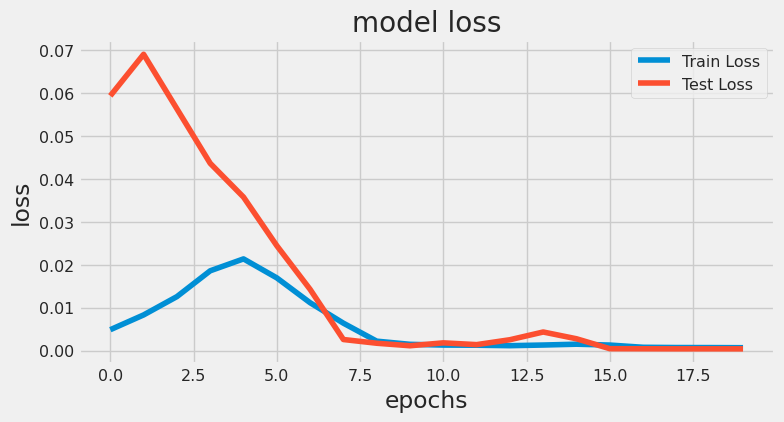

In [11]:

print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.show();

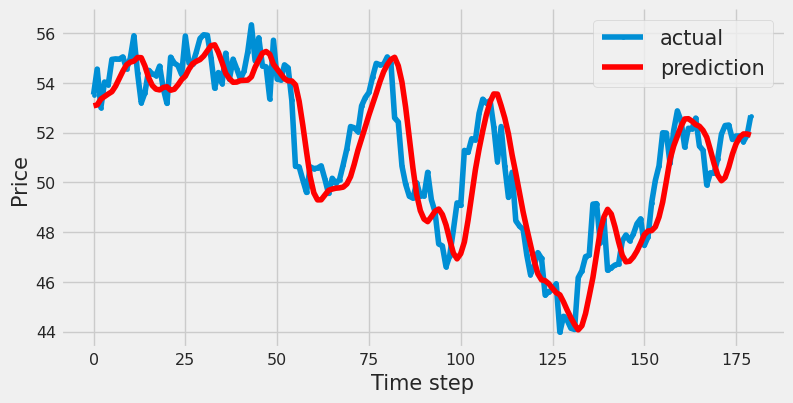

In [12]:
#Compare Actual vs. Prediction
aa=[x for x in range(180)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][:180], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][:180], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

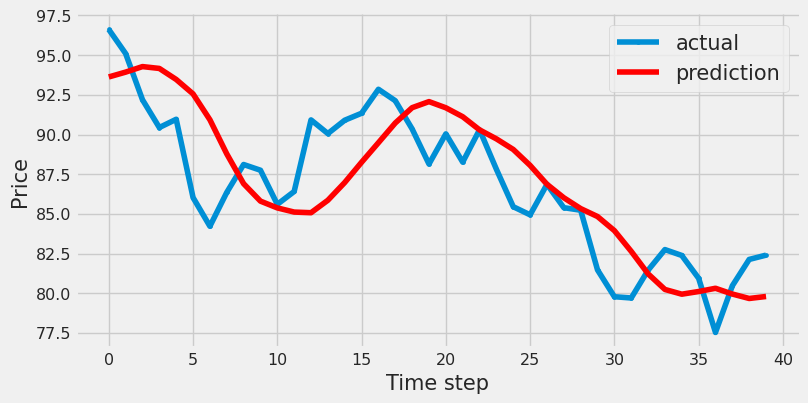

In [13]:
#Compare Actual vs. Prediction
aa=[x for x in range(40)]
plt.figure(figsize=(8,4))
plt.plot(aa, Y_test[0][-40:], marker='.', label="actual")
plt.plot(aa, test_predict[:,0][-40:], 'r', label="prediction")
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
plt.ylabel('Price', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

In [14]:
Y_test_r = Y_test.reshape(len(Y_test[0]), 1)
Y_test_inc = np.greater_equal(Y_test_r[1:], Y_test_r[:-1]).astype(int)
test_predict_inc = np.greater_equal(test_predict[1:], test_predict[:-1]).astype(int)

In [15]:
Y_train_r = Y_train.reshape(len(Y_train[0]), 1)
Y_train_inc = np.greater_equal(Y_train_r[1:], Y_train_r[:-1]).astype(int)
train_predict_inc = np.greater_equal(train_predict[1:], train_predict[:-1]).astype(int)

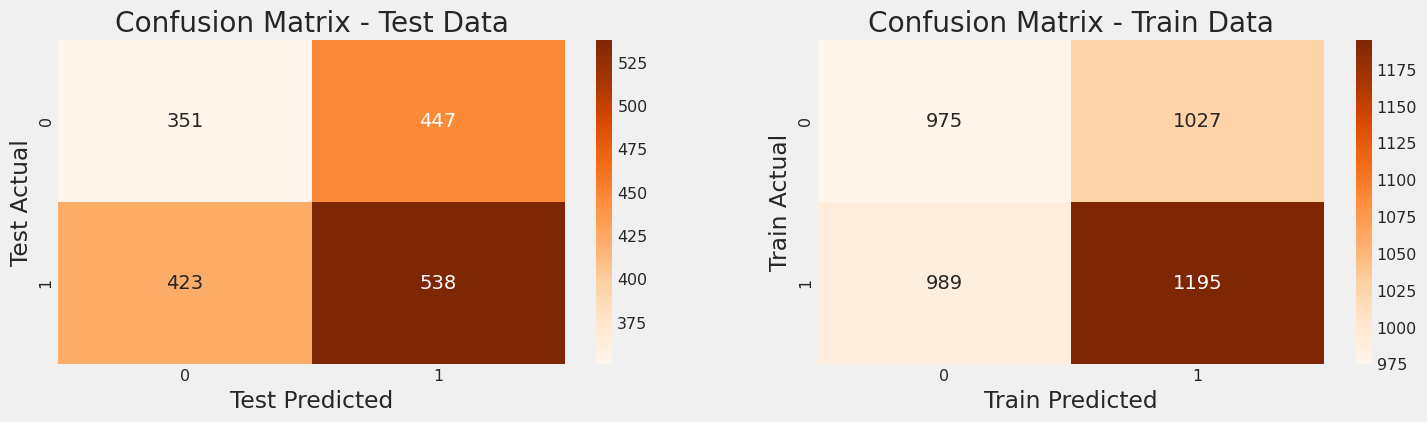

In [19]:
from sklearn.metrics import confusion_matrix, classification_report

conf_matrix_test = confusion_matrix(Y_test_inc, test_predict_inc)
conf_matrix_train = confusion_matrix(Y_train_inc, train_predict_inc)

plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Test Predicted')
plt.ylabel('Test Actual')
plt.title('Confusion Matrix - Test Data')

plt.subplot(1, 2, 2)
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Oranges')
plt.xlabel('Train Predicted')
plt.ylabel('Train Actual')
plt.title('Confusion Matrix - Train Data')

plt.show()

In [20]:
classificationreport = classification_report(Y_test_inc, test_predict_inc)
print("Classification Report (TEST Data):")
print(classificationreport)


# Adding some space between the reports for clarity
print("\n" + "=" * 40 + "\n")

classification_report2 = classification_report(Y_train_inc, train_predict_inc)
print("Classification Report (TRAIN Data):")
print(classification_report2)


Classification Report (TEST Data):
              precision    recall  f1-score   support

           0       0.45      0.44      0.45       798
           1       0.55      0.56      0.55       961

    accuracy                           0.51      1759
   macro avg       0.50      0.50      0.50      1759
weighted avg       0.50      0.51      0.50      1759



Classification Report (TRAIN Data):
              precision    recall  f1-score   support

           0       0.50      0.49      0.49      2002
           1       0.54      0.55      0.54      2184

    accuracy                           0.52      4186
   macro avg       0.52      0.52      0.52      4186
weighted avg       0.52      0.52      0.52      4186

